In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load Stock Feature Data ===
df_long = pd.read_excel("Stock_Features_Complete.xlsx")

# Ensure proper datetime format
df_long["Date"] = pd.to_datetime(df_long["Date"])

# Sort the dataset
df_long = df_long.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)

# Quick check
print("Tickers:", df_long["Ticker"].unique()[:5])
print(df_long.head())


Tickers: ['A UN Equity' 'AAPL UW Equity' 'ABBV UN Equity' 'ABT UN Equity'
 'ACGL UW Equity']
        Date       Ticker  Closing_Price  Simple_Return  Log_Return  \
0 2020-03-31  A UN Equity          71.62            NaN         NaN   
1 2020-04-30  A UN Equity          76.66       0.070371    0.068006   
2 2020-05-29  A UN Equity          88.14       0.149752    0.139546   
3 2020-06-30  A UN Equity          88.37       0.002609    0.002606   
4 2020-07-31  A UN Equity          96.33       0.090076    0.086247   

   Rolling_20D_Volatility  SMA_50  SMA_200     EMA_12     EMA_26      MACD  \
0                     NaN     NaN      NaN  71.620000  71.620000  0.000000   
1                     NaN     NaN      NaN  72.395385  71.993333  0.402051   
2                     NaN     NaN      NaN  74.817633  73.189383  1.628250   
3                     NaN     NaN      NaN  76.902613  74.313873  2.588740   
4                     NaN  84.224   84.224  79.891441  75.944697  3.946744   

     RSI  S

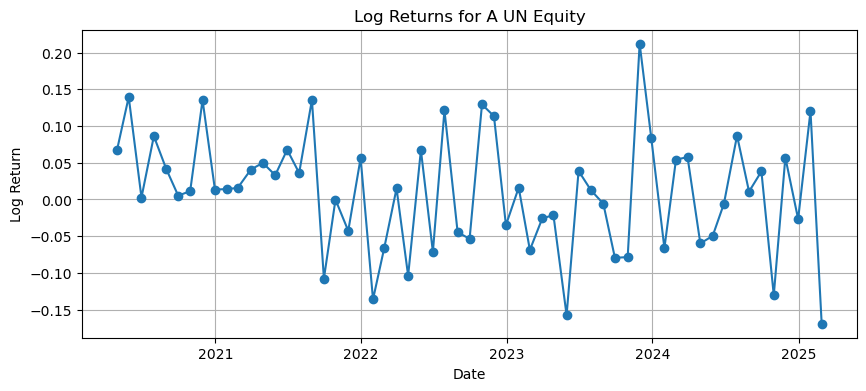

In [2]:
# Choose one ticker to sanity check
sample_ticker = "A UN Equity"
df_sample = df_long[df_long["Ticker"] == sample_ticker].set_index("Date")

plt.figure(figsize=(10, 4))
plt.plot(df_sample.index, df_sample["Log_Return"], marker='o')
plt.title(f"Log Returns for {sample_ticker}")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()


In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model results storage
arima_results = {}

# Forecast horizon (monthly returns)
forecast_horizon = 5

tickers = df_long["Ticker"].unique()

for ticker in tickers:
    df_stock = df_long[df_long["Ticker"] == ticker].set_index("Date")
    log_returns = df_stock["Log_Return"].dropna()

    if len(log_returns) < 30:
        arima_results[ticker] = {"status": "Insufficient data"}
        continue

    # Step 1: Stationarity check
    adf_stat, adf_pval = adfuller(log_returns)[:2]
    d = 0 if adf_pval < 0.05 else 1
    
    try:
        # Step 2: Fit ARIMA
        model = ARIMA(log_returns, order=(1, d, 1))
        model_fit = model.fit()

        # Step 3: Forecast future log returns
        forecast = model_fit.forecast(steps=forecast_horizon)

        # Step 4: Convert to predicted prices
        last_price = df_stock["Closing_Price"].dropna().iloc[-1]
        pred_prices = [last_price * np.exp(sum(forecast[:i])) for i in range(1, forecast_horizon + 1)]

        arima_results[ticker] = {
            "status": "OK",
            "d": d,
            "forecasted_log_returns": forecast.tolist(),
            "predicted_prices": pred_prices
        }

    except Exception as e:
        arima_results[ticker] = {"status": "Error", "error": str(e)}


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will b